In [34]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [35]:

bag = rosbag.Bag('/home/uware/rosbags/21h7_slz_2-4-6-8-10_720_30.bag')

# create variables
target = 'distance - z'
true_value = 'true_distance'

# input values in meters. the order matters, it will be used for binning 
input_vals = [2,4,6,8]

In [36]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t
    distance = msg.transforms[0].transform.translation.z

    # print(msg.transforms[0].header.stamp.secs, msg.transforms[0].header.stamp.nsecs)
    
    # create row
    row={'time': time.to_sec(), target: distance}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [37]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,distance - z
0,0.000000,2.430687
1,0.218874,2.614680
2,0.380940,2.629880
3,0.541120,2.695564
4,0.697738,2.618116
...,...,...
517,96.338140,8.140831
518,96.511105,8.141663
519,96.673471,8.141918
520,96.845557,8.124509


<AxesSubplot:xlabel='relative_time'>

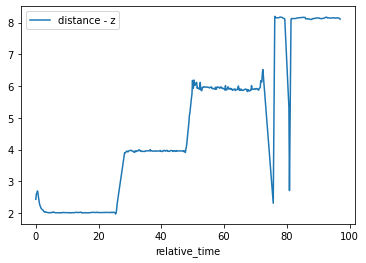

In [38]:
# initial graph
df.plot(x='relative_time', y=target)

In [39]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, .075)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [40]:
# the amount of data points we are left with
len(x[peaks])

119

In [41]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='distance - z'>

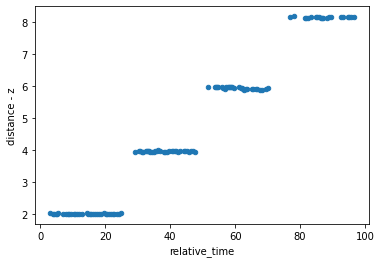

In [42]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [43]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
df_filtered_by_targets

,relative_time,distance - z,true_distance
18,2.936158,2.041478,2
23,3.913008,2.013368,2
25,4.237694,2.007004,2
28,4.719299,2.016744,2
31,5.200831,2.017338,2
...,...,...,...
503,93.171525,8.147755,8
509,94.672021,8.150569,8
511,95.001554,8.150294,8
516,95.835752,8.148643,8


In [44]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [45]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [46]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,distance - z,true_distance,error
18,2.936158,2.041478,2,-0.041478
23,3.913008,2.013368,2,-0.013368
168,29.116024,3.951261,4,0.048739
176,30.425614,3.974336,4,0.025664
303,51.598205,5.958337,6,0.041663
315,53.695579,5.977248,6,0.022752
431,77.003307,8.151496,8,-0.151496
435,78.003331,8.172979,8,-0.172979


In [47]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_distance,,,,,,,,
2,35.0,-0.016429,0.007562,-0.041478,-0.019948,-0.015010,-0.011326,-0.007004
4,33.0,0.038391,0.012024,0.004073,0.030392,0.041326,0.045221,0.057117
6,30.0,0.067271,0.032973,0.022752,0.034834,0.072886,0.095370,0.121238
8,21.0,-0.143146,0.017570,-0.172979,-0.151496,-0.147755,-0.125757,-0.113195


In [48]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

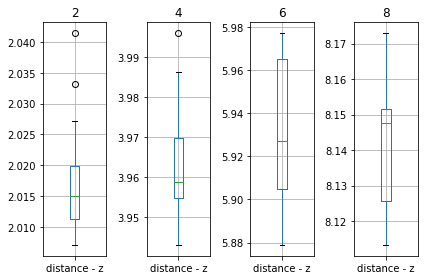

In [49]:
box_plotter(target)

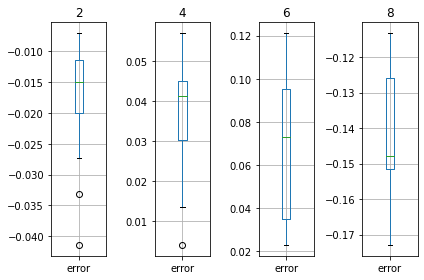

In [50]:
box_plotter('error')